In [1]:
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy as sp

## Distances between vertices of a hypercube

We want to generate all the vectors on the vertices an $N$-dimensional cube.  The coordinates for these vectors are either -1 or 1.  The set of all such vectors is $\{-1, 1\} \times \cdots \times \{-1, 1\} = \{-1, 1\}^N$.

In [3]:
def enumerate_vectors(nr_components):
    return map(np.array,
               itertools.product((-1, 1), repeat=nr_components))

For a 3-dimentional cube, this yields the 8 vertices.

In [4]:
for vector in enumerate_vectors(3):
    print(vector)

[-1 -1 -1]
[-1 -1  1]
[-1  1 -1]
[-1  1  1]
[ 1 -1 -1]
[ 1 -1  1]
[ 1  1 -1]
[1 1 1]


Define the cosine similarity (https://en.wikipedia.org/wiki/Cosine_similarity).

In [5]:
def cos_similarity(v1, v2):
    return np.dot(v1, v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))

We can now compute the similarities for all pairs of vertices in $N$ dimensions.

In [6]:
def compute_similarities(nr_components):
    return np.array([
        cos_similarity(v1, v2)
        for v1, v2 in itertools.product(enumerate_vectors(nr_components),
                                        enumerate_vectors(nr_components))
    ])

It would be nice to show this in a historgram.

In [7]:
def plot_similarities(nr_components):
    print(f'N = {nr_components}, 2^N = {2**nr_components} vectors')
    similarities = compute_similarities(nr_components)
    unique_similarities = np.unique(similarities)
    unique_similarities.sort()
    _, _, patches = plt.hist(similarities, bins=len(unique_similarities),
                             density=True, alpha=0.7, edgecolor='black')
    plt.xlim(-1.1, 1.1);
    xticks = [patch.get_x() + 0.5*patch.get_width() for patch in patches]
    xlabels = [f'{x:.3f}' for x in unique_similarities]
    plt.xticks(xticks, xlabels, rotation='vertical')
    plt.show()

N = 2, 2^N = 4 vectors


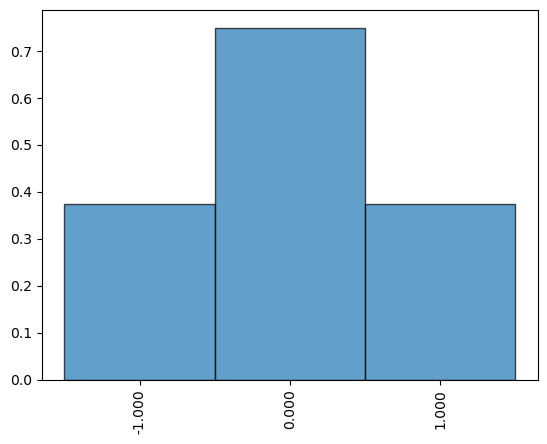

N = 3, 2^N = 8 vectors


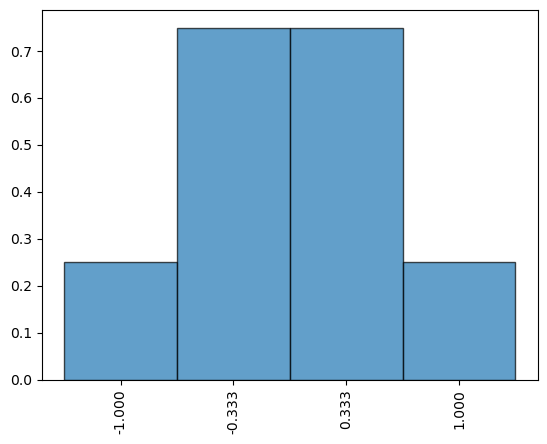

N = 4, 2^N = 16 vectors


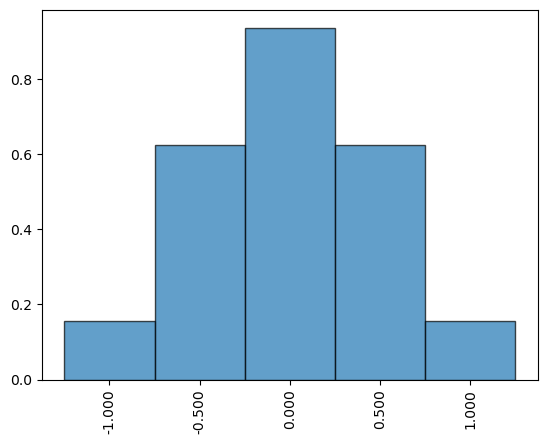

N = 5, 2^N = 32 vectors


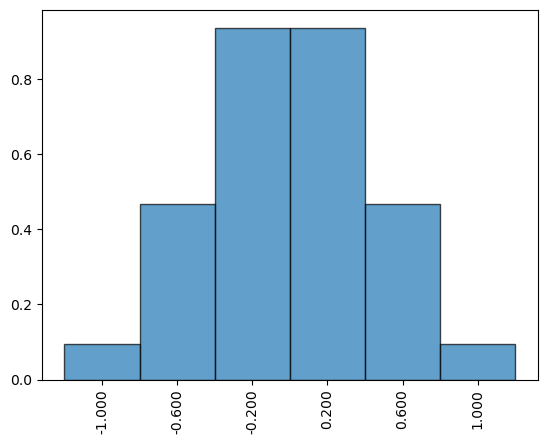

N = 6, 2^N = 64 vectors


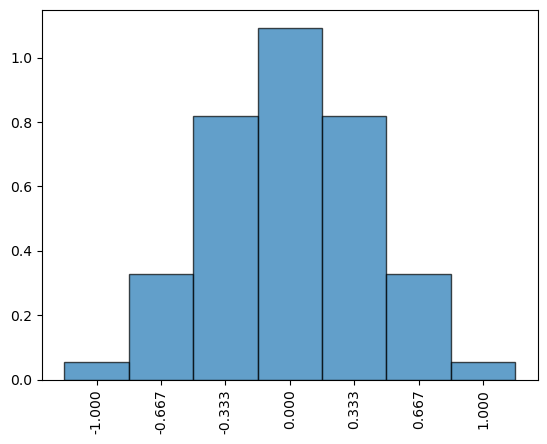

N = 7, 2^N = 128 vectors


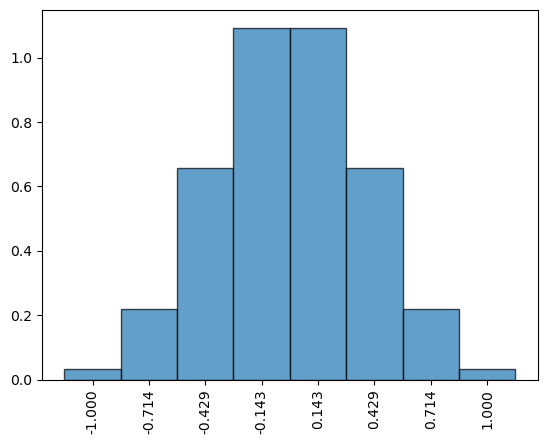

N = 8, 2^N = 256 vectors


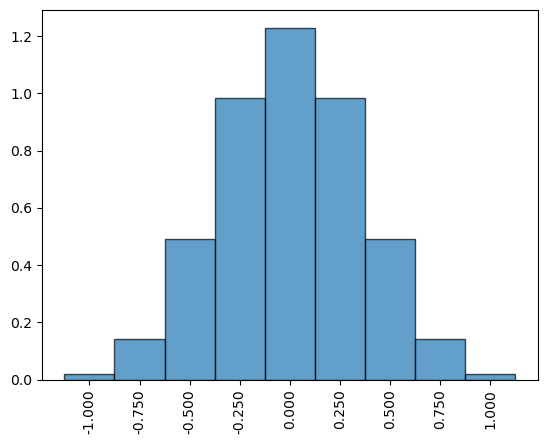

N = 9, 2^N = 512 vectors


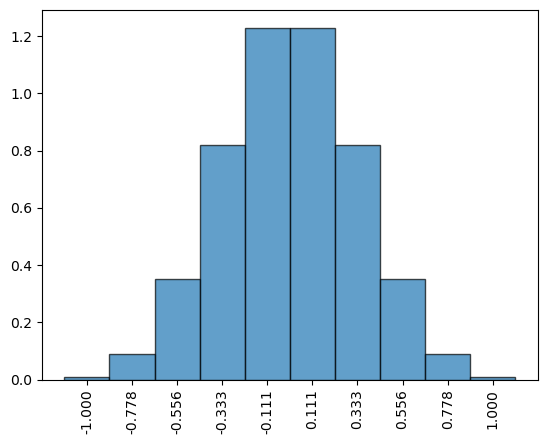

N = 10, 2^N = 1024 vectors


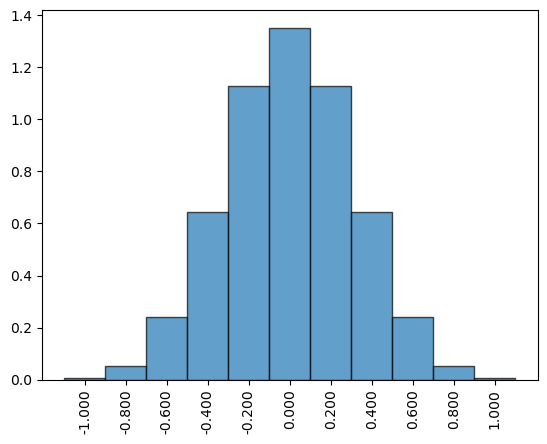

In [8]:
for nr_components in range(2, 11):
    plot_similarities(nr_components)

The vast majority of these vectors have a very low similarity.

## Distances in $n$ dimensions

Create a sample of $N$ points from a hypercube in $n$-dimensional space.

In [5]:
def create_sample(dims, nr_points):
    return np.random.uniform(-1.0, 1.0, size=(nr_points, dims))

The following function computes the minimal and maximal value of a point in the $n$-dimensional hypercube to the sample points.

In [18]:
def min_max_distance(point, sample):
    distances = sp.linalg.norm(sample - point, axis=1, ord=2)
    return np.min(distances), np.max(distances)

In [19]:
sample = create_sample(dims=2, nr_points=5)

In [20]:
sample

array([[ 0.7591533 , -0.19311657],
       [-0.4506866 , -0.67009723],
       [-0.16436871,  0.02569073],
       [ 0.24683949, -0.47790371],
       [ 0.56312788,  0.29778503]])

In [21]:
min_max_distance(np.array([0.0, 0.0]), sample)

(0.1663643177600079, 0.8075572463632475)

## Ratio of an inscribed hypersphere in a hypercube

What is the ration of the volume of a hypersphere of radius 1 that is inscribed in a hypercube?

This can be estimated by randomly generating points in the hypercube, and count how many are in the hypersphere, i.e., their distance from the origin is less than 1.

In [25]:
def compute_fraction(dim, nr_points):
    points = np.random.uniform(-1.0, 1.0, size=(nr_points, dim))
    return np.sum(np.where(np.sum(points**2, axis=1) < 1.0, 1, 0))/points.shape[0]

In [26]:
dims = list(range(1, 16))
ratios = [compute_fraction(dim, 10_000_000) for dim in dims]

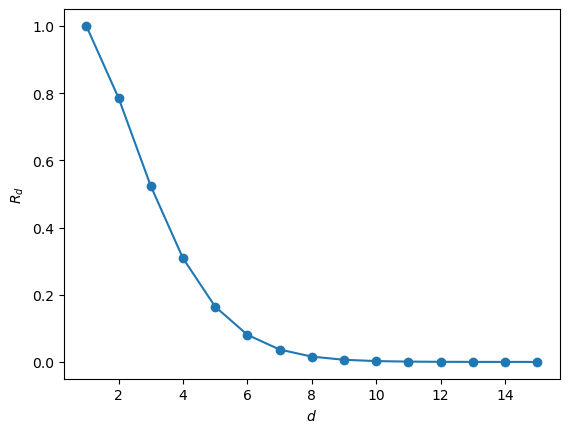

In [27]:
plt.plot(dims, ratios, 'o-');
plt.xlabel('$d$');
plt.ylabel('$R_d$');

Since the volume of a $d$-dimensional sphere is given by
$$
    V_{\mathrm{sphere}} = \frac{2r^d\pi^{d/2}}{d\Gamma(d/2)}
$$
and that of a $d$-dimensional cube by
$$
    V_{\mathrm{cube}} = (2r)^d
$$
the ratio is given by
$$
    R_d = \frac{\pi^{d/2}}{d2^{d - 1}\Gamma(d/2)}
$$

In [28]:
d = np.linspace(1.0, 15.0, 101)
R_d = np.pi**(d/2)/(d*2**(d - 1)*sp.special.gamma(d/2))

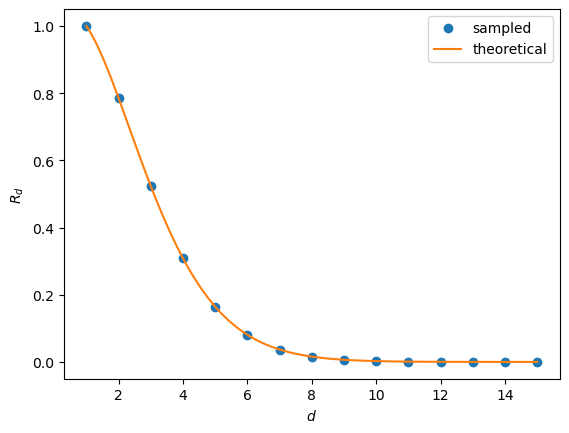

In [29]:
plt.plot(dims, ratios, 'o', label='sampled');
plt.xlabel('$d$');
plt.ylabel('$R_d$');
plt.plot(d, R_d, label='theoretical');
plt.legend();

It is clear that the ration rapidly drops to 0 with increasing dimension $d$. So although the hypersphere touches the hypercube in $2^d$ points, its volume is nevertheless much smaller.